In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline


In [4]:
# Import the modules we will be using
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#import mplsoccer to demo creating a pitch on gridsearch
from mplsoccer import Pitch
from mplsoccer import VerticalPitch
import sqlite3
from highlight_text import fig_text, ax_text

import requests


import bs4
import json
from PIL import Image
import urllib

In [5]:
con = sqlite3.connect("Database/opta_event_data22_23.db")
cur = con.cursor()

data = pd.read_sql("Select * from Matches Where match_id = 1694372", con)
data


,level_0,Unnamed: 0,eventId,minute,second,teamId,x,y,expandedMinute,period,...,Venue,xThreat,xThreat_gen,playerName,is_open_play,is_progressive,is_pass_into_box,won_possession,is_carry_into_box,progressive_carry
0,0,None,2.0,0.0,0.0,26,0.0,0.0,0.0,1.0,...,Away,NaN,NaN,Unknown,1,0,NaN,0,NaN,NaN
1,1,None,2.0,0.0,0.0,52,0.0,0.0,0.0,1.0,...,Home,NaN,NaN,Unknown,1,0,NaN,0,NaN,NaN
2,2,None,3.0,0.0,0.0,26,50.0,50.0,0.0,1.0,...,Away,-0.004436,0.000000,Mohamed Salah,1,0,NaN,0,NaN,NaN
3,3,None,3.5,0.0,1.5,26,30.6,41.0,0.0,1.0,...,None,0.000757,0.000757,Ibrahima Konaté,1,0,NaN,0,NaN,NaN
4,4,None,4.0,0.0,3.0,26,34.9,36.0,0.0,1.0,...,Away,NaN,NaN,Ibrahima Konaté,1,0,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,1890,None,11531.0,51.0,NaN,52,66.8,70.3,54.0,2.0,...,Home,NaN,NaN,Vinícius Júnior,1,0,NaN,0,NaN,NaN
1891,1891,None,910.0,0.0,0.0,52,0.0,0.0,7.0,NaN,...,Home,NaN,NaN,Unknown,1,0,NaN,0,NaN,NaN
1892,1892,None,836.0,0.0,0.0,26,0.0,0.0,7.0,NaN,...,Away,NaN,NaN,Unknown,1,0,NaN,0,NaN,NaN
1893,1893,None,1.0,0.0,0.0,52,0.0,0.0,0.0,NaN,...,Home,NaN,NaN,Unknown,1,0,NaN,0,NaN,NaN


In [32]:
def plot_xT_flow_chart(ax, home_color, away_color, data):

    team_names = data['team_name'].unique()

    # Further manipulation based on team
    data_list = []
    for name in team_names:
        if name == 'Liverpool':
            data_list.append(
                data.loc[data['team_name'] == name]
                .assign(xThreat_gen=lambda x: np.where(x['xThreat_gen'] > 0, x['xThreat_gen'], -x['xThreat_gen']))
            )
        else:
            data_list.append(
                data.loc[data['team_name'] == name]
                .assign(xThreat_gen=lambda x: np.where(x['xThreat_gen'] > 0, -x['xThreat_gen'], x['xThreat_gen']))
            )

    # Combine datasets and group by minute
    df = (pd.concat(data_list)
          .groupby('minute')
          .agg({'xThreat_gen': 'sum'})
          .reset_index()
          )

    # Interpolate data for a smoother line which goes through all plotted points
    spline = make_interp_spline(df['minute'], df['xThreat_gen'], k=3)
    spline_int = pd.DataFrame({'minute': np.linspace(df['minute'].min(), df['minute'].max(), 2000)})
    spline_int['xThreat_gen'] = spline(spline_int['minute'])
    spline_int['team_name'] = np.where(spline_int['xThreat_gen'] > 0, team_names[0], team_names[1])



    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.axvline(45, c='#018b95', linestyle = '--')


    # remove the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticklabels([])
    fig.set_facecolor("#201D1D")
    ax.set_facecolor("#201D1D")
    ax.grid(False)

    # Plot and fill between lines
    for name, color, hatch in zip(team_names, [home_color, away_color], ['////', '\\\\\\\\']):
        ax.plot(spline_int['minute'], np.where(spline_int['team_name'] == name, spline_int['xThreat_gen'], np.nan), color=color, lw=1)
        ax.fill_between(spline_int['minute'], spline_int['xThreat_gen'], where=spline_int['team_name'] == name, color=color, alpha=0.2, interpolate=True, edgecolor=color, hatch=hatch, lw=0)


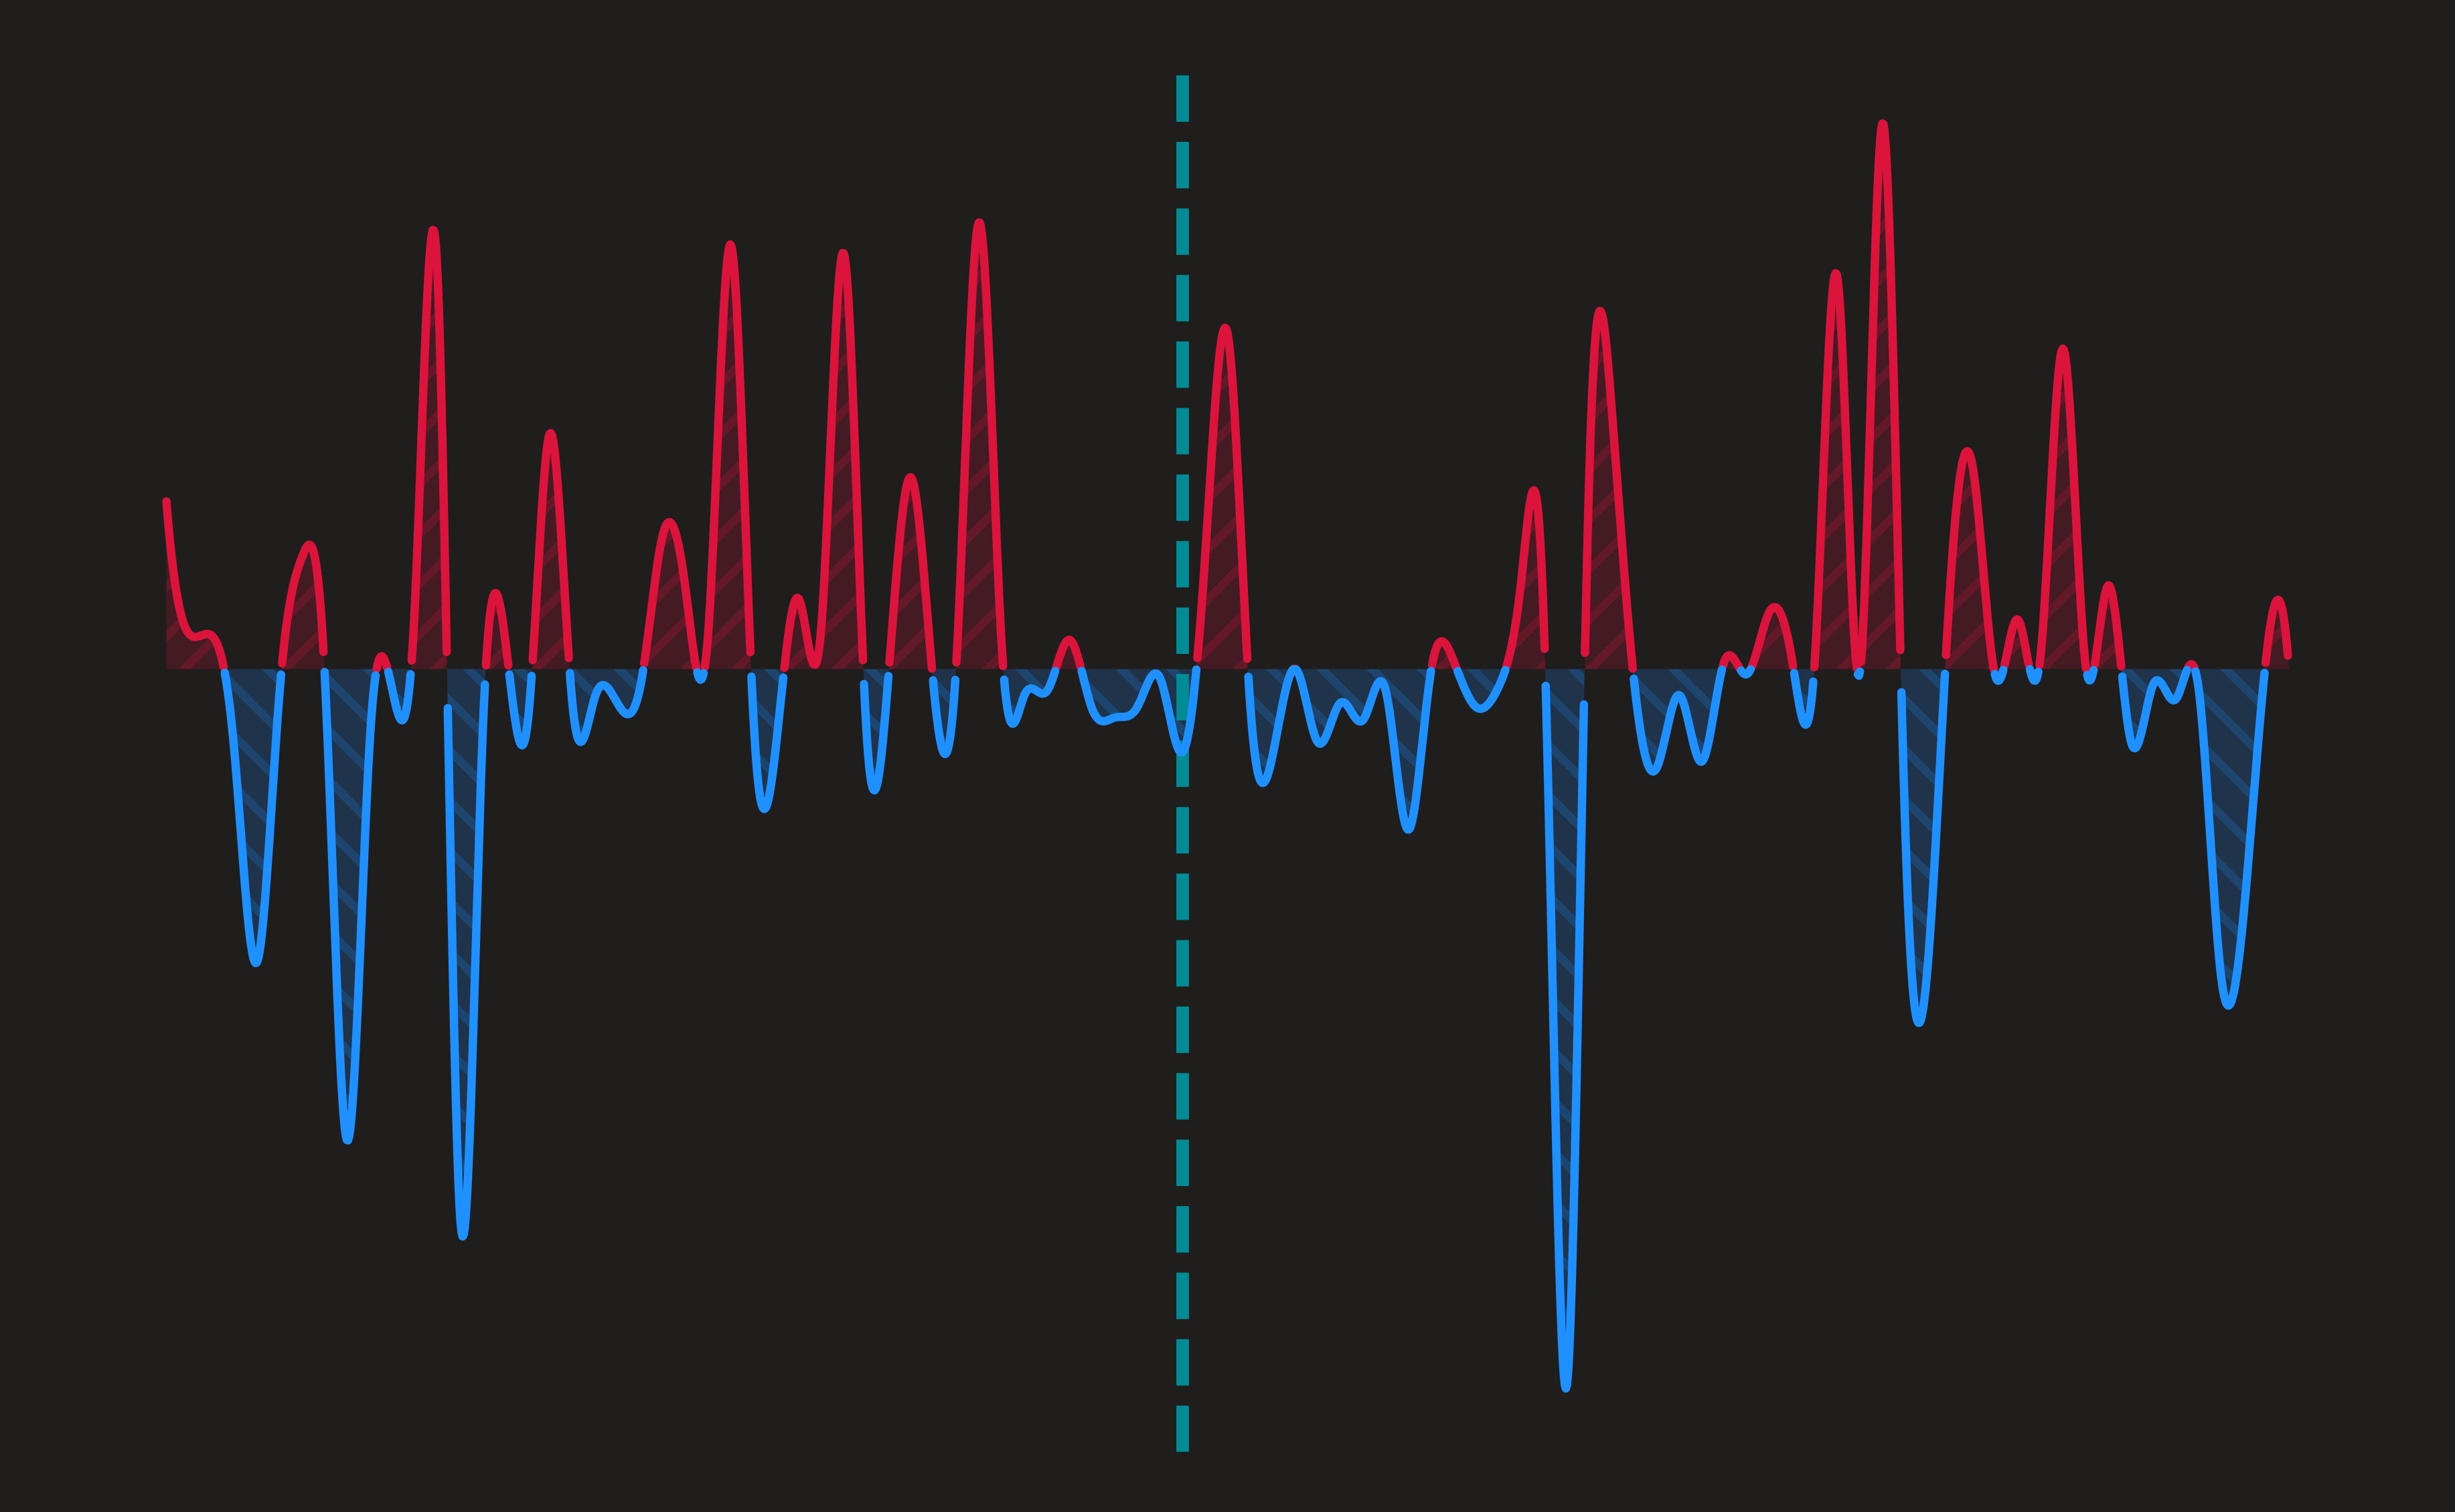

In [33]:
# Set up plot
fig = plt.figure(figsize=(5, 3), dpi=900)
ax = plt.subplot(111)

plot_xT_flow_chart(ax, '#dc143c', '#1e90ff', data)

In [30]:
def plot_xT_flow_chart(ax, home_color, away_color, data):

    team_names = data['team_name'].unique()

    # Further manipulation based on team
    data_list = []
    for name in team_names:
        if name == 'Liverpool':
            data_list.append(
                data.loc[data['team_name'] == name]
                .assign(xThreat_gen=lambda x: np.where(x['xThreat_gen'] > 0, x['xThreat_gen'], -x['xThreat_gen']))
            )
        else:
            data_list.append(
                data.loc[data['team_name'] == name]
                .assign(xThreat_gen=lambda x: np.where(x['xThreat_gen'] > 0, -x['xThreat_gen'], x['xThreat_gen']))
            )

    # Combine datasets and group by minute
    df = (pd.concat(data_list)
          .groupby('minute')
          .agg({'xThreat_gen': 'sum'})
          .reset_index()
          )

    # Interpolate data for a smoother line which goes through all plotted points
    spline = make_interp_spline(df['minute'], df['xThreat_gen'], k=3)
    spline_int = pd.DataFrame({'minute': np.linspace(df['minute'].min(), df['minute'].max(), 250)})
    spline_int['xThreat_gen'] = spline(spline_int['minute'])
    spline_int['team_name'] = np.where(spline_int['xThreat_gen'] > 0, team_names[0], team_names[1])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.axvline(45, c='#018b95', linestyle = '--')

    # remove the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xticks([])
    ax.set_yticks(np.linspace(df['xThreat_gen'].min(), df['xThreat_gen'].max(), 5))  # set ytick locations
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticklabels([f"{x:.2f}" for x in np.linspace(df['xThreat_gen'].min(), df['xThreat_gen'].max(), 5)])  # set ytick labels
    fig.set_facecolor("#201D1D")
    ax.set_facecolor("#201D1D")
    ax.grid(False)

    # Plot and fill between lines
    for name, color, hatch in zip(team_names, [home_color, away_color], ['////', '\\\\\\\\']):
        ax.plot(spline_int['minute'], np.where(spline_int['team_name'] == name, spline_int['xThreat_gen'], np.nan), color=color, lw=1)
        ax.fill_between(spline_int['minute'], spline_int['xThreat_gen'], where=spline_int['team_name'] == name, color=color, alpha=0.2, interpolate=True, edgecolor=color, hatch=hatch, lw=0)


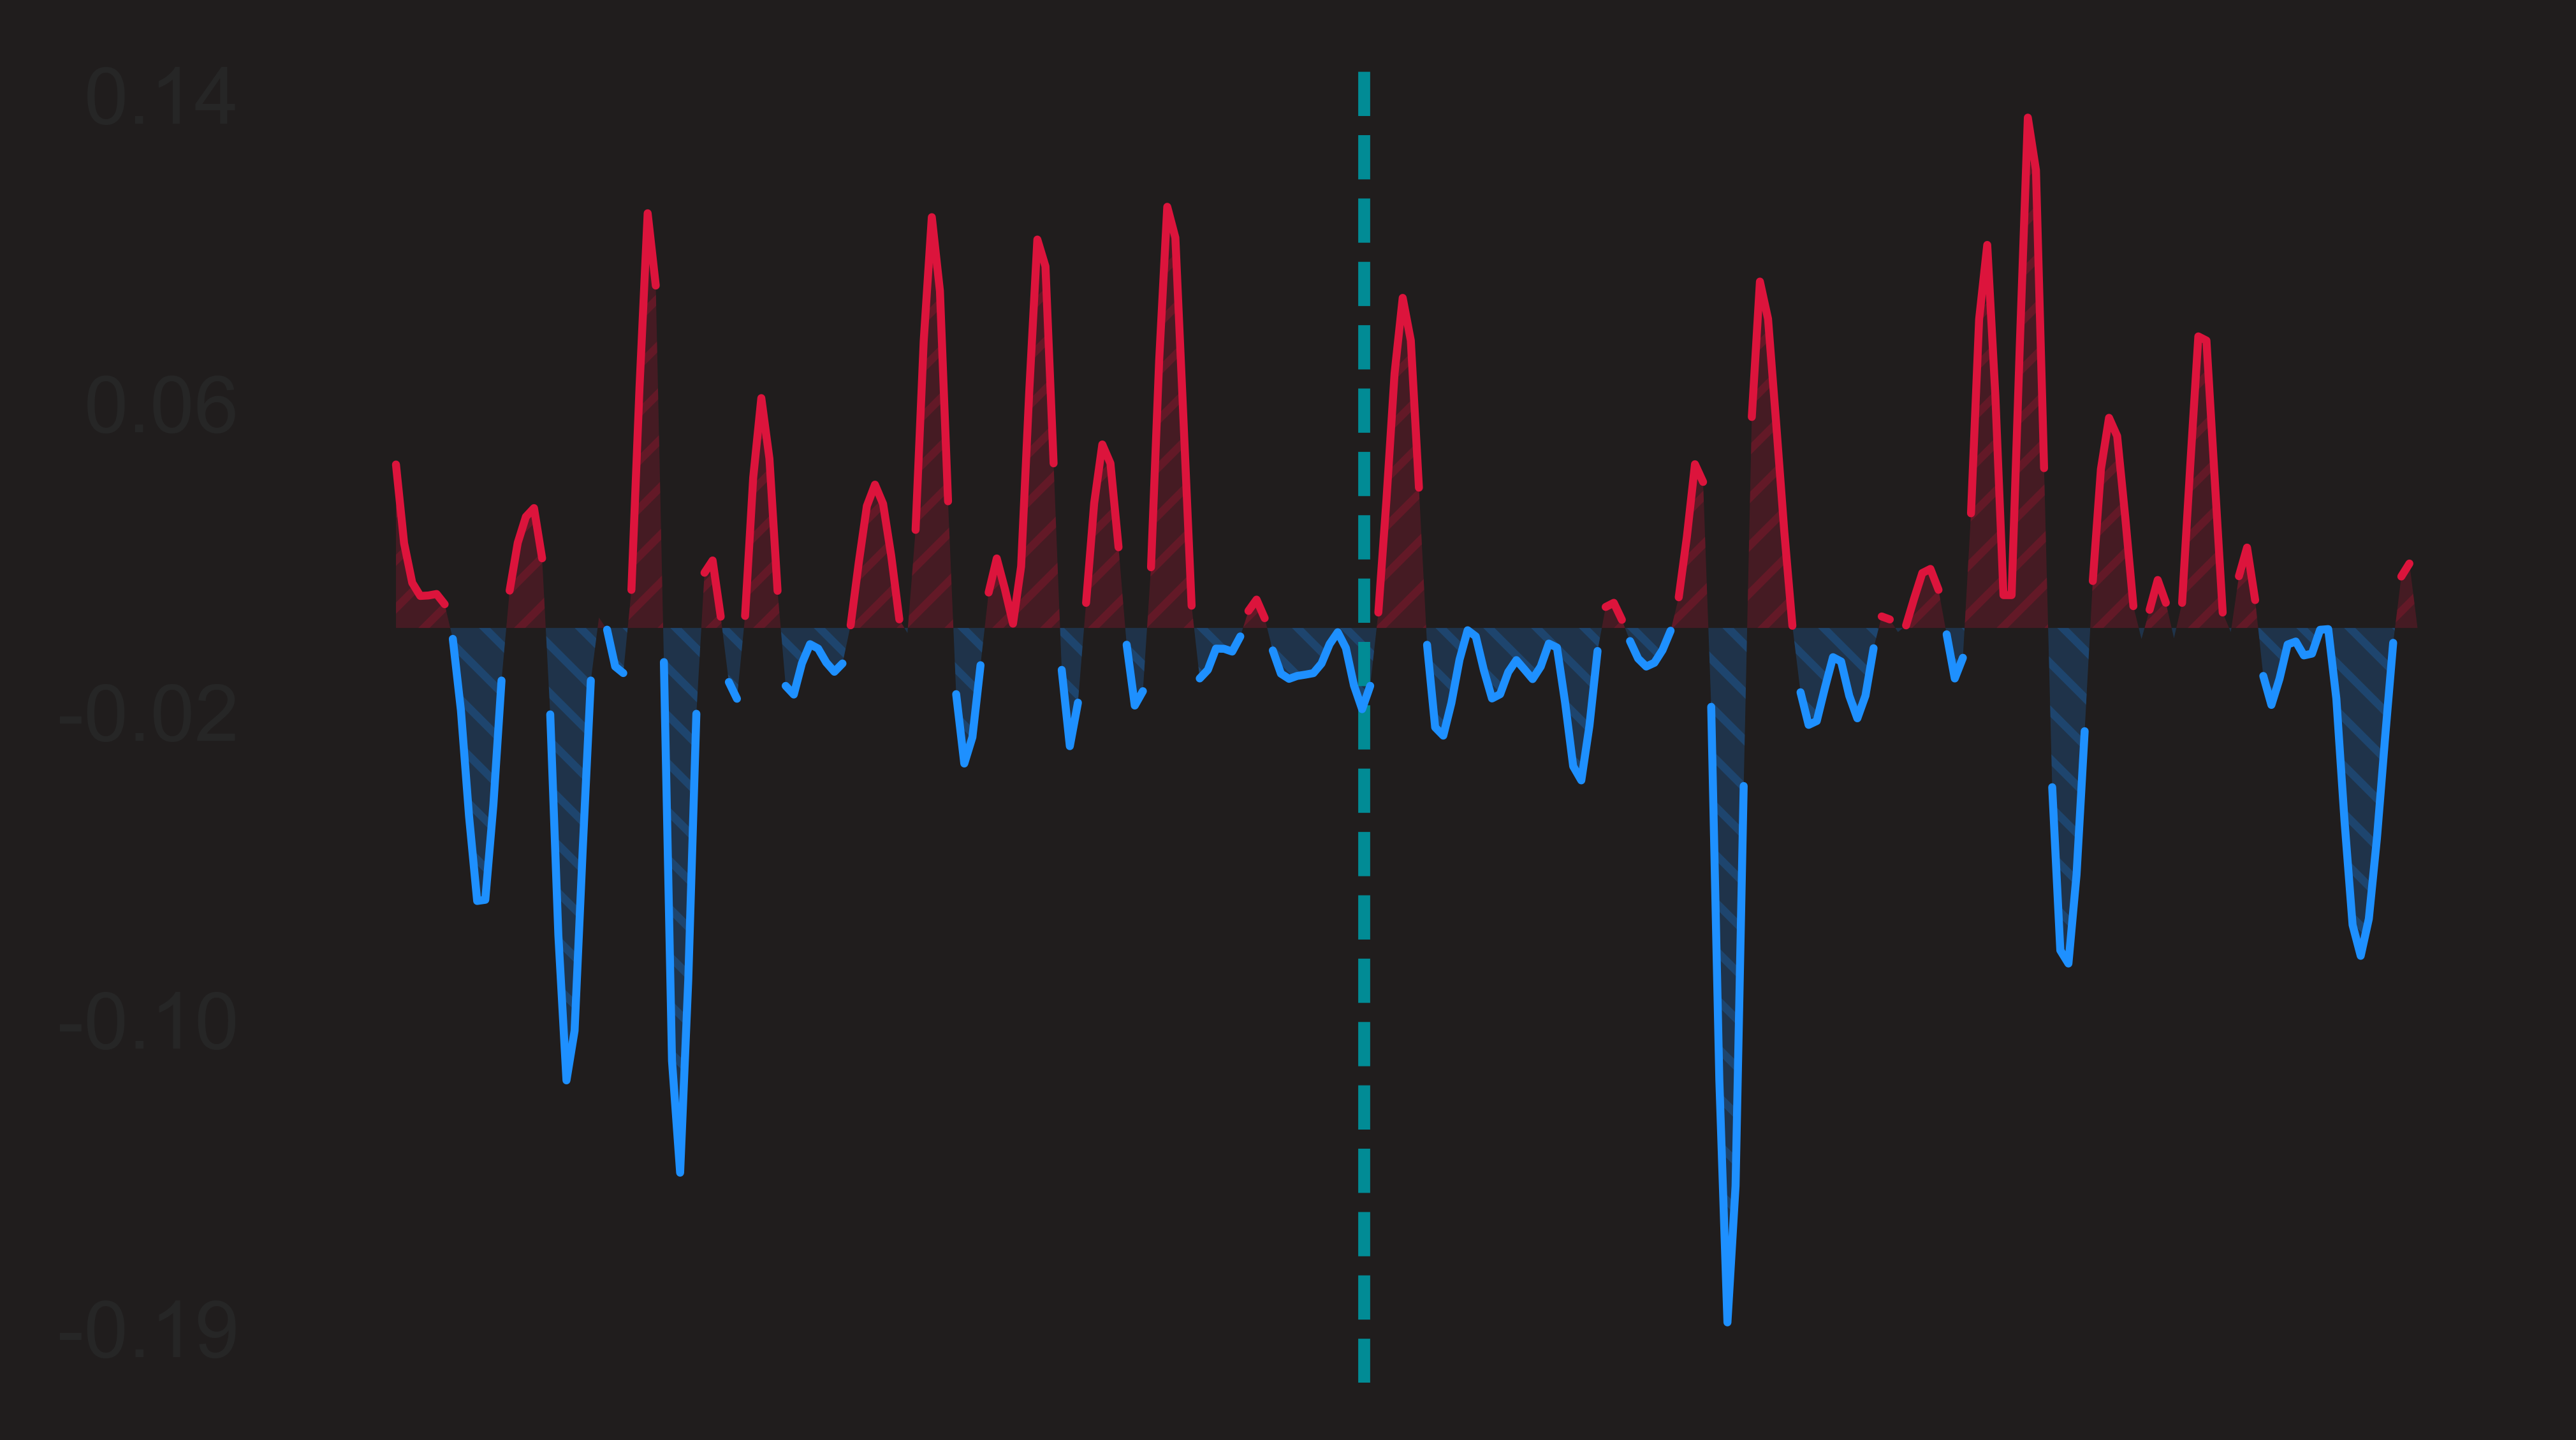

In [31]:
# Set up plot
fig = plt.figure(figsize=(5, 3), dpi=900)
ax = plt.subplot(111)

plot_xT_flow_chart(ax, '#dc143c', '#1e90ff', data)